In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from glob import glob
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow

# What's that's look like ?

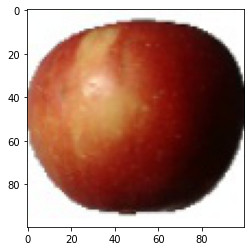

In [ ]:
image = imread("/content/drive/MyDrive/Colab Notebooks/fruits-360/Training/Apple Braeburn/0_100.jpg")
plt.imshow(image)

## Image Size

In [ ]:
image.shape

(100, 100, 3)

In [ ]:
IMSIZE = [100, 100]

# Data Augmentation with TF Generator

In [ ]:
src_path_train = "/content/drive/MyDrive/Colab Notebooks/fruits-360/Training"
src_path_test = "/content/drive/MyDrive/Colab Notebooks/fruits-360/Test"
batch_size = 32

image_gen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.20)

# create generators
train_generator = image_gen.flow_from_directory(
  src_path_train,
  target_size=IMSIZE,
  shuffle=True,
  batch_size=batch_size,
)

test_generator = image_gen.flow_from_directory(
  src_path_test,
  target_size=IMSIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 67703 images belonging to 131 classes.
Found 19543 images belonging to 131 classes.


131 classes (labels)

In [ ]:
NBCLASSES = 131

Number of files

In [ ]:
train_image_files = glob(src_path_train + '/*/*.jp*g')
test_image_files = glob(src_path_test + '/*/*.jp*g')
print("Train File Nb:", len(train_image_files))
print("Test File Nb:", len(test_image_files))

Train File Nb: 67703
Test File Nb: 19543


# Model creation from VGG-16

In [ ]:
def create_model():
    vgg = VGG16(input_shape=IMSIZE + [3], weights='imagenet', include_top=False)

    # Freeze existing VGG already trained weights
    for layer in vgg.layers:
        layer.trainable = False
    
    # get the VGG output
    out = vgg.output
    
    # Add new dense layer at the end
    x = Flatten()(out)
    x = Dense(NBCLASSES, activation='softmax')(x)
    
    model = Model(inputs=vgg.input, outputs=x)
    
    model.compile(loss="binary_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])
    
    model.summary()
    
    return model

mymodel = create_model()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0   

# Fit model

In [ ]:
epochs = 30
early_stop = EarlyStopping(monitor='val_loss',patience=2)

r = mymodel.fit(
  train_generator,
  validation_data=test_generator,
  epochs=epochs,
  steps_per_epoch=len(train_image_files) // batch_size,
  validation_steps=len(test_image_files) // batch_size,
  callbacks=[early_stop]
)

Epoch 1/30
  26/2115 [..............................] - ETA: 4:18:41 - loss: 0.2427 - accuracy: 0.0182

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-b95d95696c0f>", line 10, in <module>
    callbacks=[early_stop]
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py", line 1100, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 855, in _call
    return self._stateless_fn(*args, **kwds)  # pylint: disable=not-callable
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/function.py", line 2943, in __call__
    filtered_flat_args, captured_inputs=graph_function.captured_inputs)  # pylint: disable=protected-access
  File "/u

KeyboardInterrupt: ignored

# Evaluation

In [ ]:
score = mymodel.evaluate_generator(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])